In [1]:
from segment_anything import sam_model_registry, SamPredictor
from dataset import SAMAugmentedDataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.cm as cm
device='cuda'
sam = sam_model_registry['vit_b'](checkpoint="/CV/gaobiaoli/project/weights/sam_vit_b_01ec64.pth").to(device)
predictor = SamPredictor(sam)
dataset = SAMAugmentedDataset(image_dir="/CV/gaobiaoli/dataset/CIS-Dataset/train", sam=sam)
(image, warped_mask), flow = dataset[6]

/home/gaobiaoli/miniconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torchvision.models import swin_t
from torchvision.models.swin_transformer import SwinTransformer
backbone = swin_t(weights='IMAGENET1K_V1')

torch.Size([860, 1840, 3])

In [4]:
image.shape

torch.Size([3, 860, 1840])

In [ ]:
import cv2
import os
from segment_anything import SamAutomaticMaskGenerator
import numpy as np
idx=6
img_path = os.path.join(dataset.image_dir, dataset.image_files[idx])
# image = cv2.imread(img_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


/tmp/ipykernel_45648/411391404.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))


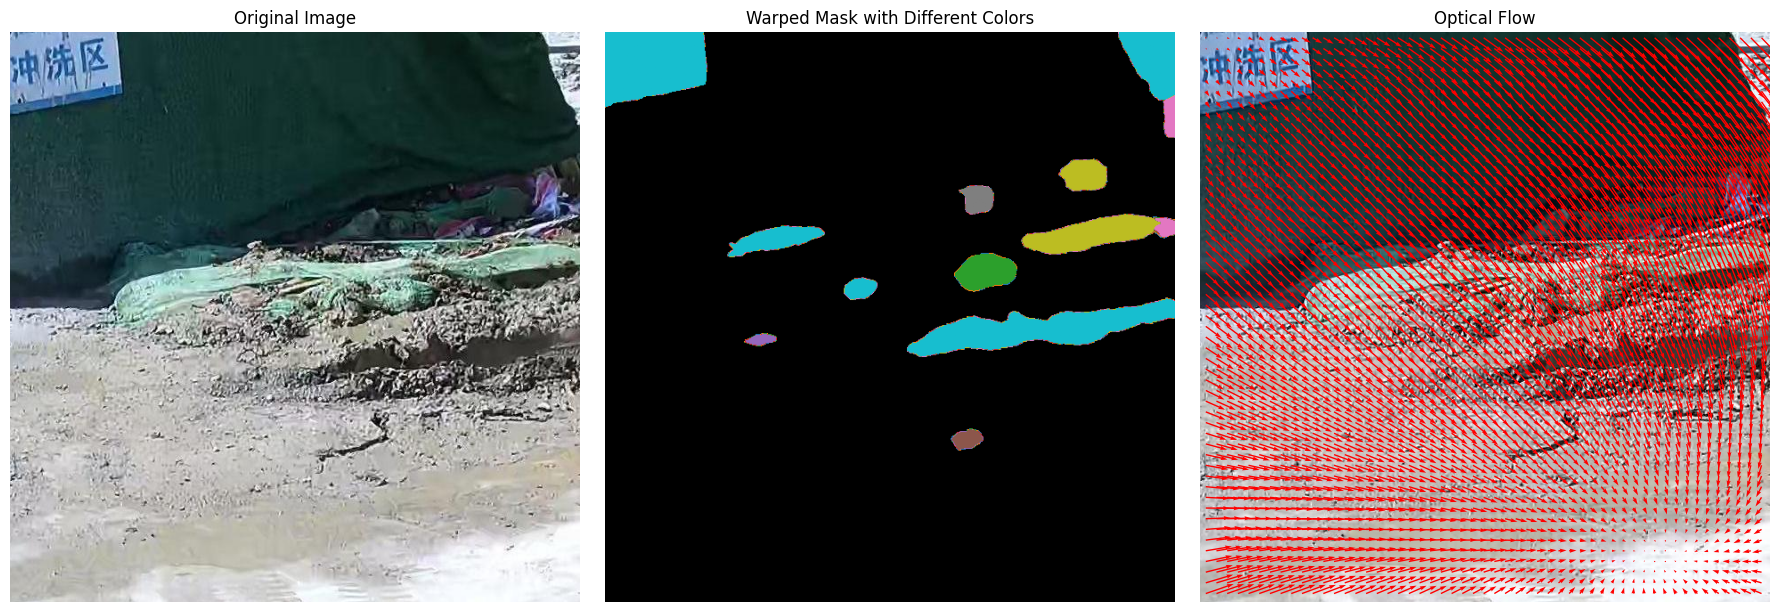

In [3]:

def visualize_results(image, warped_mask, flow):
    # 将张量转换为numpy数组
    image = image.permute(1, 2, 0).cpu().numpy()
    warped_mask = warped_mask.squeeze(0).cpu().numpy()
    flow = flow.permute(1, 2, 0).cpu().numpy()

    # 创建图像网格
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 显示原始图像
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # 显示扭曲后的mask，映射至不同颜色中
    unique_labels = np.unique(warped_mask)
    colored_mask = np.zeros((*warped_mask.shape, 3), dtype=np.float32)
    colormap = cm.get_cmap('tab10', len(unique_labels))
    for i, label in enumerate(unique_labels):
        if label > 0:  # 忽略背景
            colored_mask[warped_mask == label] = colormap(i)[:3]

    axs[1].imshow(colored_mask)
    axs[1].set_title("Warped Mask with Different Colors")
    axs[1].axis("off")

    # 显示光流图像
    h, w, _ = flow.shape
    step = 12  # 步长，用于绘制箭头
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    axs[2].imshow(image)
    axs[2].quiver(x, y, fx, fy, color='r', angles='xy', scale_units='xy', scale=1)
    axs[2].set_title("Optical Flow")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()
visualize_results(image,warped_mask,flow)

/tmp/ipykernel_45648/3828950134.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(unique_labels))


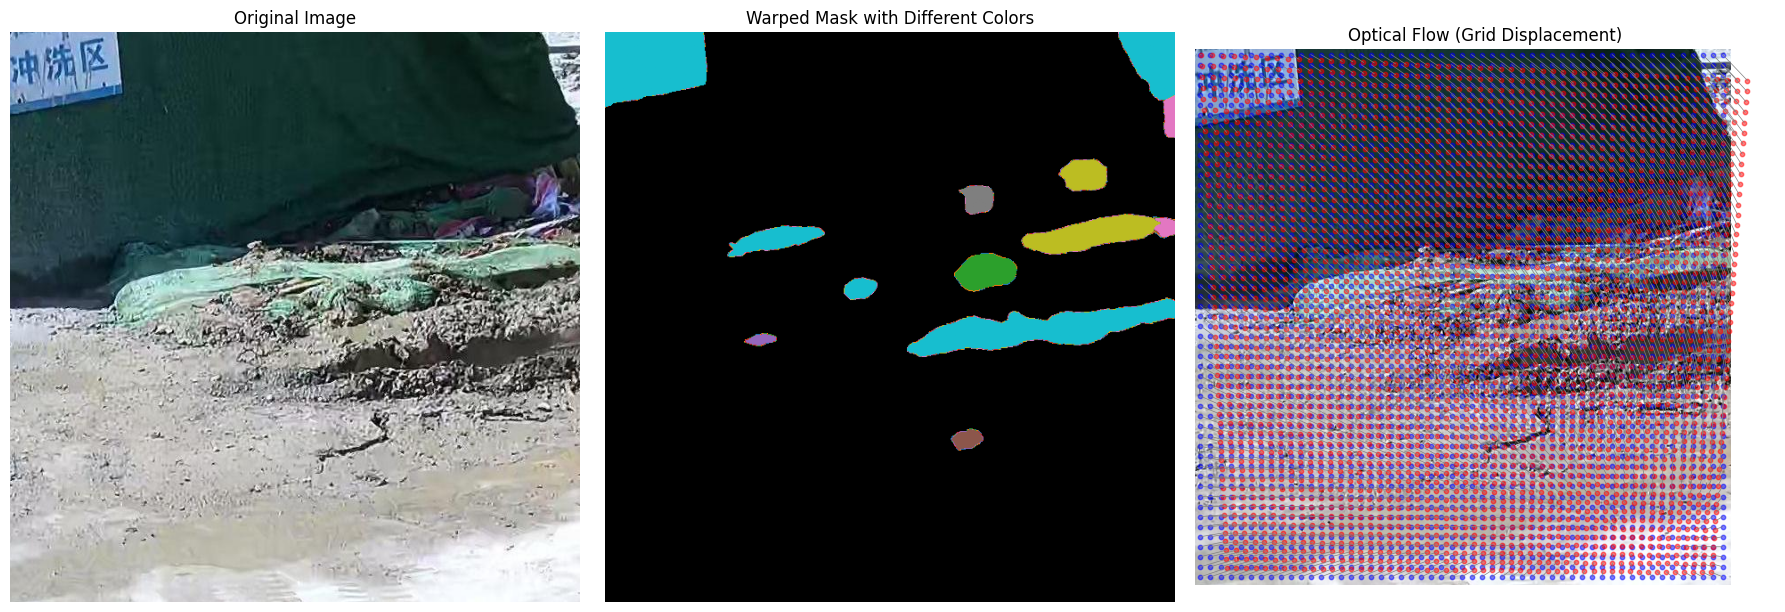

: 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_results(image, warped_mask, flow):
    # 将张量转换为numpy数组
    image = image.permute(1, 2, 0).cpu().numpy()
    warped_mask = warped_mask.squeeze(0).cpu().numpy()
    flow = flow.permute(1, 2, 0).cpu().numpy()

    # 创建图像网格
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 显示原始图像
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # 显示扭曲后的mask，映射至不同颜色中
    unique_labels = np.unique(warped_mask)
    colored_mask = np.zeros((*warped_mask.shape, 3), dtype=np.float32)
    colormap = cm.get_cmap('tab10', len(unique_labels))
    for i, label in enumerate(unique_labels):
        if label > 0:  # 忽略背景
            colored_mask[warped_mask == label] = colormap(i)[:3]

    axs[1].imshow(colored_mask)
    axs[1].set_title("Warped Mask with Different Colors")
    axs[1].axis("off")

    # 计算光流的网格可视化（光流后位置的变换）
    h, w, _ = flow.shape
    step = 12  # 步长，用于绘制网格的点
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)

    # 提取光流的 x 和 y 分量
    fx, fy = flow[y, x].T

    # 计算原始网格点的坐标
    original_grid = np.vstack((x, y)).T

    # 计算网格点扭曲后的新位置
    displaced_grid = original_grid + np.column_stack((fx, fy))

    # 绘制网格和变形后的网格
    axs[2].imshow(image)
    axs[2].scatter(x, y, c='blue', s=10, alpha=0.5)  # 原始网格点
    axs[2].scatter(displaced_grid[:, 0], displaced_grid[:, 1], c='red', s=10, alpha=0.5)  # 扭曲后的网格点

    # 连接原始网格点和变形后网格点
    for i in range(len(original_grid)):
        axs[2].plot([original_grid[i, 0], displaced_grid[i, 0]],
                    [original_grid[i, 1], displaced_grid[i, 1]],
                    color='gray', lw=0.5)

    axs[2].set_title("Optical Flow (Grid Displacement)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(image,warped_mask,flow)